# Connections Analysis Notebook GPT-3.5

Purpose is to evaluate the performance of GPT-2 and GPT-3.5 on Connections game.

By: Elsie Wang

Date: 03/18/24

## Overhead

In [346]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from json import load
import csv
from collections import defaultdict

from openai import OpenAI
import torch
import transformers
from transformers import AutoTokenizer

In [420]:
from json import load

KEY = load(open('./SECRETS.json', 'r'))
client = OpenAI(api_key=KEY['OpenAIKey'])

### Load Data

In [49]:
answers_dict = defaultdict(list)
with open("data/answers.csv", newline='') as csvfile:
    # Create a CSV reader object
    reader = csv.reader(csvfile)
    
    # Iterate over each row in the CSV file
    for row in reader:
        if len(row) == 4:
            continue
        else:
            answers_dict['Game_ID'].append(row[0])
            answers_dict['Words'].append([row[i].replace("'", "").strip("[]\'").strip() for i in range(1,5)])
            answers_dict['Color'].append(row[-1])
            if len(row) == 8:
                answers_dict['Category'].append(f"{row[5]}, {row[6]}")
            else:
                answers_dict['Category'].append(row[5])
answers_df = pd.DataFrame(answers_dict)
answers_df.head()

,Game_ID,Words,Color,Category
0,1,"[HAIL, RAIN, SLEET, SNOW]",yellow,WET WEATHER
1,1,"[BUCKS, HEAT, JAZZ, NETS]",green,NBA TEAMS
2,1,"[OPTION, RETURN, SHIFT, TAB]",blue,KEYBOARD KEYS
3,1,"[KAYAK, LEVEL, MOM, RACECAR]",purple,PALINDROMES
4,2,"[BOOT, LOAFER, PUMP, SNEAKER]",yellow,FOOTWEAR


In [242]:
prompts_dict = defaultdict(list)
with open("data/prompt.csv", newline='') as csvfile:
    # Create a CSV reader object
    reader = csv.reader(csvfile)
    
    # Iterate over each row in the CSV file
    for row in reader:
        if len(row) == 2:
            continue
        else:
            prompts_dict['Game_ID'].append(row[0])
            prompts_dict['Options'].append([row[i].replace("'", "").strip("[]").strip() for i in range(1, len(row))])
prompts_df = pd.DataFrame(prompts_dict)
prompts_df.head()

,Game_ID,Options
0,1,"[HAIL, LEVEL, RETURN, OPTION, SNOW, NETS, TAB,..."
1,2,"[MILE, LOAFER, LEAGUE, TIME, BOOT, ESSENCE, SN..."
2,3,"[POM, TENOR, WOLF, PEKE, SCARF, KING, PIT, GOB..."
3,4,"[REEBOK, DUST, SPIDER, ADIDAS, CABARET, SWEEP,..."
4,5,"[HULU, LOW, KETCHUP, RELISH, GREEN, GLUM, SCAR..."


In [473]:
# Combine answers and prompts df
def filter_options(row):
    """ Returns a list of options without the words in the Words column
    """
    return [word for word in row['Options'] if word not in row['Prompt']]

# Apply the function to create the new options column
merged = answers_df.merge(prompts_df, on='Game_ID', how='left')
merged['Prompt'] = merged['Words'].apply(lambda x: x[:3])
merged['Options'] = merged.apply(filter_options, axis=1)
merged['Correct_Answer'] = merged['Words'].apply(lambda x: x[-1])
merged.head()

,Game_ID,Words,Color,Category,Options,Prompt,Correct_Answer
0,1,"[HAIL, RAIN, SLEET, SNOW]",yellow,WET WEATHER,"[LEVEL, RETURN, OPTION, SNOW, NETS, TAB, KAYAK...","[HAIL, RAIN, SLEET]",SNOW
1,1,"[BUCKS, HEAT, JAZZ, NETS]",green,NBA TEAMS,"[HAIL, LEVEL, RETURN, OPTION, SNOW, NETS, TAB,...","[BUCKS, HEAT, JAZZ]",NETS
2,1,"[OPTION, RETURN, SHIFT, TAB]",blue,KEYBOARD KEYS,"[HAIL, LEVEL, SNOW, NETS, TAB, KAYAK, HEAT, JA...","[OPTION, RETURN, SHIFT]",TAB
3,1,"[KAYAK, LEVEL, MOM, RACECAR]",purple,PALINDROMES,"[HAIL, RETURN, OPTION, SNOW, NETS, TAB, HEAT, ...","[KAYAK, LEVEL, MOM]",RACECAR
4,2,"[BOOT, LOAFER, PUMP, SNEAKER]",yellow,FOOTWEAR,"[MILE, LEAGUE, TIME, ESSENCE, SNEAKER, US, PEO...","[BOOT, LOAFER, PUMP]",SNEAKER


-------------------------------------------------------------------------------------------------------------------

## Query GPT Responses

### GPT-3.5

GPT-3.5 will be tested on whether they can find the word that has the most in common with three words given a set of options. One example is given below:

**Prompt**:

Find the word that shares the most in common with ['BLUE', 'GREEN', 'PURPLE'] among the follwoing words and ONLY the following words:

['HULU', 'YELLOW', 'KETCHUP', 'RELISH', 'SCARF', 'LETTUCE', 'PRIME', 'MUSTARD', 'TOMATO', 'MAYO', 'PEACOCK', 'NETFLIX', 'TARTAR'].

DO NOT REPEAT THE THREE WORDS GIVEN. Give a one word answer. E.g. 'BLUE'

**Response**:

'YELLOW'

In [466]:
def surprisal(p):
    """ Returns surprisal (negative log probability)
    """
    if p == 0:
        return 0
    else:
        return -np.log2(p)

In [379]:
def calc_prob(response):
    """ Returns probability of response generated by GPT
    """
    logprobs = []
    contents = response.choices[0].logprobs.content
    for content in contents:
        logprobs.append(content.logprob)
    return np.exp(sum(logprobs))

In [411]:
def run_eval_category(words, options, correct_answer):
    """ Prompts GPT to answer categories individually and returns response and probability (e.g. RED, BLUE, YELLOW, ____)
    """
    
    prompt = f"Find the word that shares the most in common with {words} among the follwoing words and ONLY the following words:\n{options}.\nGive a one word answer. E.g. 'BLUE'"
    # Prompt GPT-3.5 5 times and get most common response
    response = client.chat.completions.create(
        model="gpt-3.5-turbo", 
        max_tokens=200, 
        temperature=0.7,
        stop=None,  
        messages=[{"role": "user", "content": prompt}],
        logprobs=True
    )
        
    answer = response.choices[0].message.content # Get answer
    prob = calc_prob(response) # probability of answer
    
    correct = answer == correct_answer # Whether GPT guessed correctly


    # Print and record the answer
    return answer, prob, correct
    # Record the answer to a file
#     with open("answers.txt", "a") as f:
#         f.write(answer + "\n")

In [421]:
responses = []
probs = []
correct_ = []

# Tests GPT on all categories 
for index, row in tqdm(merged.iterrows(), total=len(merged)):
    prompt = row['Prompt']
    options = row['Options']
    correct_answer = row['Correct_Answer']
    
    answer, prob, correct = run_eval_category(prompt, options, correct_answer)
    responses.append(answer)
    probs.append(prob)
    correct_.append(correct)

100%|█████████████████████████████████████████| 340/340 [43:07<00:00,  7.61s/it]


In [476]:
# Add results to column
merged3 = merged.copy()
merged3['Response'] = responses
merged3['Probabilities'] = probs
merged3['Correct'] = correct_
merged3['Surprisal'] = merged3['Probabilities'].apply(surprisal)
merged3.head()

# Write to csv
merged3.to_csv('data/results-3.csv', index=False)

merged3.head()

,Game_ID,Words,Color,Category,Options,Prompt,Correct_Answer,Response,Probabilities,Correct,Surprisal
0,1,"[HAIL, RAIN, SLEET, SNOW]",yellow,WET WEATHER,"[LEVEL, RETURN, OPTION, SNOW, NETS, TAB, KAYAK...","[HAIL, RAIN, SLEET]",SNOW,SNOW,0.996020,True,0.005754
1,1,"[BUCKS, HEAT, JAZZ, NETS]",green,NBA TEAMS,"[HAIL, LEVEL, RETURN, OPTION, SNOW, NETS, TAB,...","[BUCKS, HEAT, JAZZ]",NETS,NETS,0.989294,True,0.015529
2,1,"[OPTION, RETURN, SHIFT, TAB]",blue,KEYBOARD KEYS,"[HAIL, LEVEL, SNOW, NETS, TAB, KAYAK, HEAT, JA...","[OPTION, RETURN, SHIFT]",TAB,SHIFT,0.122644,False,3.027452
3,1,"[KAYAK, LEVEL, MOM, RACECAR]",purple,PALINDROMES,"[HAIL, RETURN, OPTION, SNOW, NETS, TAB, HEAT, ...","[KAYAK, LEVEL, MOM]",RACECAR,RACECAR,0.997618,True,0.003440
4,2,"[BOOT, LOAFER, PUMP, SNEAKER]",yellow,FOOTWEAR,"[MILE, LEAGUE, TIME, ESSENCE, SNEAKER, US, PEO...","[BOOT, LOAFER, PUMP]",SNEAKER,FOOT,0.994823,False,0.007488


### GPT-2

In [469]:
# Load pre-trained gpt2 model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2 = transformers.AutoModelForCausalLM.from_pretrained("gpt2")  # Load the model

In [470]:
def next_seq_prob(model, tokenizer, seen, unseen):
    """Get p(unseen | seen)

    Parameters
    ----------
    model : transformers.PreTrainedModel
        Model to use for predicting tokens
    tokenizer : transformers.PreTrainedTokenizer
        Tokenizer for Model
    seen : str
        Input sequence
    unseen: str
        The sequence for which to calculate a probability
    """
    # Get ids for tokens
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen)

    # Loop through unseen tokens & store log probs
    log_probs = []
    for unseen_id in unseen_ids:

        # Run model on input
        with torch.no_grad():
            logits = model(input_ids).logits

        # Get next token prediction logits
        next_token_logits = logits[0, -1]
        next_token_probs = torch.softmax(next_token_logits, 0) # Normalize

        # Get probability for relevant token in unseen string & store
        prob = next_token_probs[unseen_id]
        log_probs.append(torch.log(prob))

        # Add input tokens incrementally to input
        input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)

    # Add log probs together to get total log probability of sequence
    total_log_prob = sum(log_probs)
    # Exponentiate to return to probabilities
    total_prob = torch.exp(total_log_prob)
    return total_prob.item()

In [510]:
results = []
for index, row in tqdm(merged.iterrows(), total=len(merged)):
    probs_temp = []
    options = row['Options']
    prompts = row['Prompt']
    prompt = f"Find the word that shares the most in common with {prompts} among the following words and ONLY the following words:\n{options}.\nGive a one word answer. E.g. 'BLUE'"
    
    for candidate in options:
        prob = next_seq_prob(gpt2, tokenizer, prompt, candidate)
        probs_temp.append(prob)
        
    guess_probs = max(probs_temp)
    guess = candidates[probs_temp.index(guess_probs)]
    correct_probs = next_seq_prob(gpt2, tokenizer, prompt, row['Correct_Answer'])
    results.append({
            'Game_ID': row['Game_ID'],
            'Prompt': row['Prompt'],
            'Color': row['Color'],
            'Category': row['Category'],
            'Response': guess,
            'Response_Probability': guess_probs,
            'Response_Surprisal': surprisal(guess_probs),
            'Correct_Answer': row['Correct_Answer'],
            'Probability_Correct': correct_probs,
            'Surprisal_Correct': surprisal(correct_probs),
            'Correct': guess==row['Correct_Answer']
    })

100%|█████████████████████████████████████| 1123/1123 [1:01:17<00:00,  3.27s/it]


In [512]:
results2 = pd.DataFrame(results)

# Write to csv
results2.to_csv('data/results-2.csv', index=False)

-------------------------------------------------------------------------------------------------------------------

## Analysis

### GPT-3.5

In [519]:
def is_repeat(row):
    """ Returns whether response is in the prompt list
    """
    return row['Response'] in row['Prompt']

# Apply the function to create the new options column
merged3['Repeat'] = merged3.apply(is_repeat, axis=1)
merged3.head()

,Game_ID,Words,Color,Category,Options,Prompt,Correct_Answer,Response,Probabilities,Correct,Surprisal,Repeat
0,1,"[HAIL, RAIN, SLEET, SNOW]",yellow,WET WEATHER,"[LEVEL, RETURN, OPTION, SNOW, NETS, TAB, KAYAK...","[HAIL, RAIN, SLEET]",SNOW,SNOW,0.996020,True,0.005754,False
1,1,"[BUCKS, HEAT, JAZZ, NETS]",green,NBA TEAMS,"[HAIL, LEVEL, RETURN, OPTION, SNOW, NETS, TAB,...","[BUCKS, HEAT, JAZZ]",NETS,NETS,0.989294,True,0.015529,False
2,1,"[OPTION, RETURN, SHIFT, TAB]",blue,KEYBOARD KEYS,"[HAIL, LEVEL, SNOW, NETS, TAB, KAYAK, HEAT, JA...","[OPTION, RETURN, SHIFT]",TAB,SHIFT,0.122644,False,3.027452,True
3,1,"[KAYAK, LEVEL, MOM, RACECAR]",purple,PALINDROMES,"[HAIL, RETURN, OPTION, SNOW, NETS, TAB, HEAT, ...","[KAYAK, LEVEL, MOM]",RACECAR,RACECAR,0.997618,True,0.003440,False
4,2,"[BOOT, LOAFER, PUMP, SNEAKER]",yellow,FOOTWEAR,"[MILE, LEAGUE, TIME, ESSENCE, SNEAKER, US, PEO...","[BOOT, LOAFER, PUMP]",SNEAKER,FOOT,0.994823,False,0.007488,False


In [520]:
# Percent of responses that repeat from the prompt
np.mean(merged3['Repeat'])

0.1647373107747106

In [521]:
# Find average correct by difficulty level
grouped_repeat = merged3.groupby('Color').mean()[['Probabilities', 'Correct', 'Surprisal']]
grouped_repeat

,Probabilities,Correct,Surprisal
Color,,,
blue,0.716556,0.283688,0.885448
green,0.759423,0.478723,0.624655
purple,0.634872,0.086643,1.001186
yellow,0.823912,0.627660,0.496609


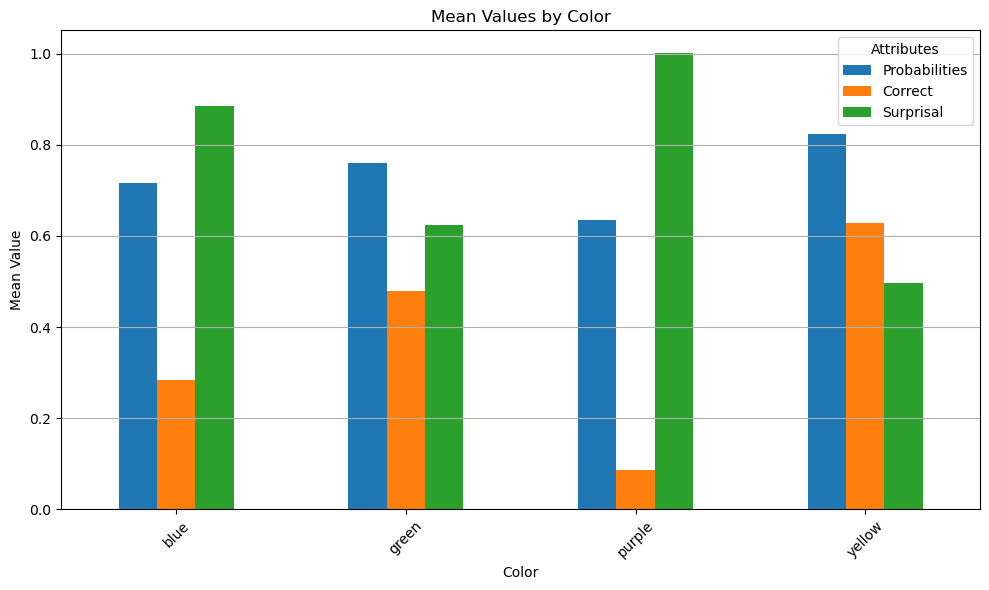

In [522]:
# Plotting the bar chart including repeats
grouped_repeat.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Values by Color')
plt.xlabel('Color')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Attributes')
plt.tight_layout()
plt.show()

In [523]:
# Filter out repeats and get difficulty results
merged_filtered = merged3[merged3['Repeat'] == False]
grouped_norepeat = merged_filtered.groupby('Color').mean()[['Probabilities', 'Correct', 'Surprisal']]
grouped_norepeat

,Probabilities,Correct,Surprisal
Color,,,
blue,0.730311,0.346320,0.893291
green,0.779832,0.574468,0.606047
purple,0.640754,0.111628,1.012317
yellow,0.831028,0.688716,0.486053


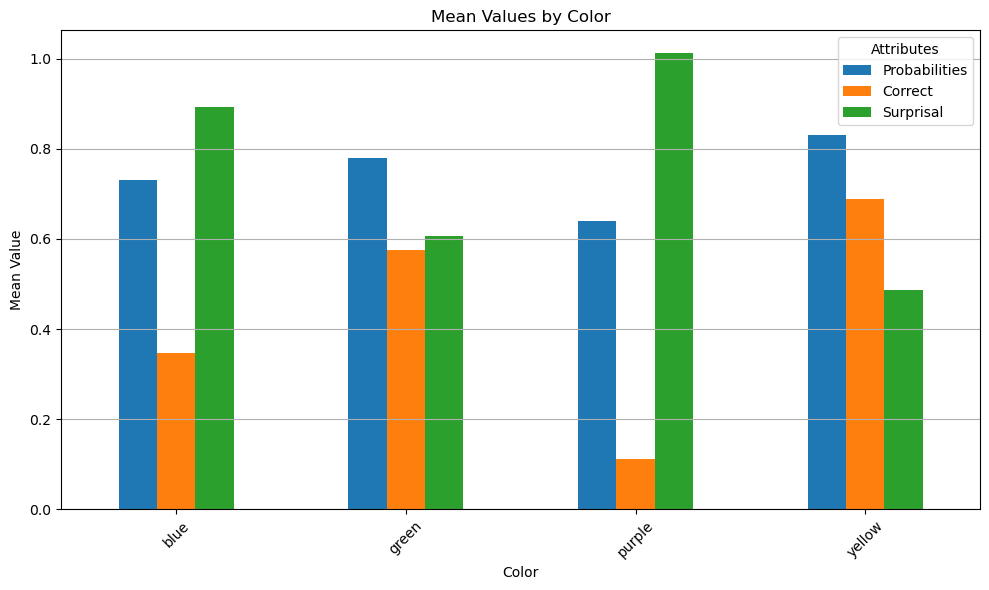

In [524]:
# Plotting the bar chart
grouped_norepeat.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Values by Color')
plt.xlabel('Color')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Attributes')
plt.tight_layout()
plt.show()

In [525]:
# Group by whether GPT guessed correctly
grouped_correct = merged3.groupby('Correct').mean()[['Surprisal']]
grouped_correct

,Surprisal
Correct,
False,1.062001
True,0.222083


<Axes: xlabel='Correct', ylabel='Surprisal'>

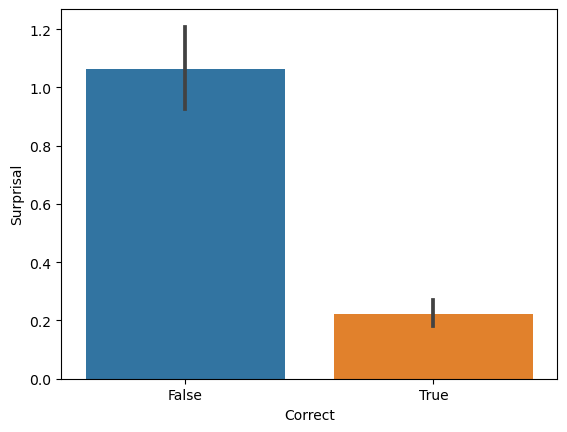

In [526]:
sns.barplot(data = merged3, x = "Correct", y = "Surprisal")

<Axes: xlabel='Color', ylabel='Surprisal'>

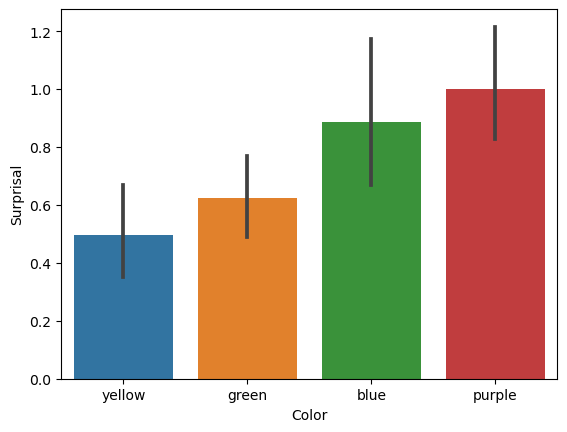

In [527]:
sns.barplot(data = merged3, x = "Color", y = "Surprisal")

### GPT-2

In [528]:
# Find accuracy of model
np.mean(results2['Correct'])

0.003561887800534283

In [516]:
# Group by color
grouped_color = results2.groupby('Color').mean()
grouped_color

,Response_Probability,Response_Surprisal,Probability_Correct,Surprisal_Correct,Correct
Color,,,,,
blue,0.000005,18.323693,8.710674e-07,22.393307,0.003546
green,0.000004,18.340462,9.619410e-07,22.298223,0.003546
purple,0.000005,18.399726,7.938414e-07,22.369003,0.000000
yellow,0.000005,18.343368,6.162374e-07,22.734313,0.007092


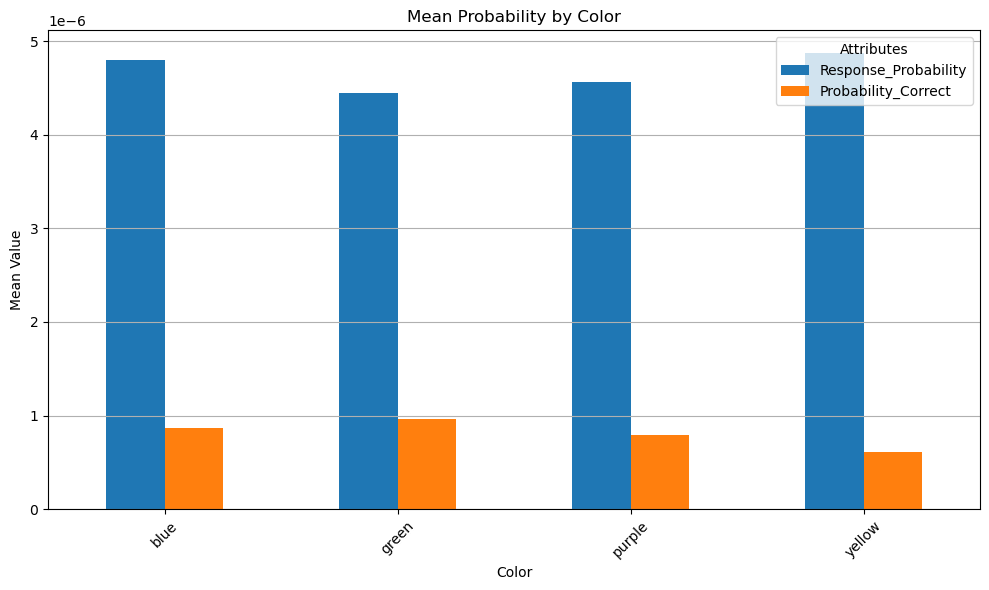

In [533]:
# Plotting the bar chart
grouped_color[['Response_Probability', 'Probability_Correct']].plot(kind='bar', figsize=(10, 6))
plt.title('Mean Probability by Color')
plt.xlabel('Color')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Attributes')
plt.tight_layout()
plt.show()

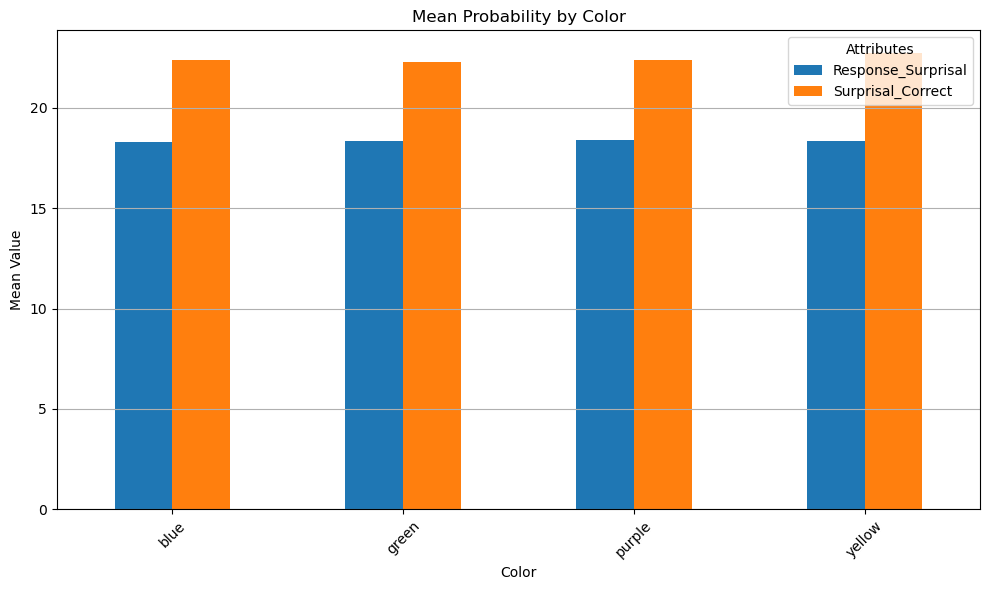

In [534]:
# Plotting the bar chart
grouped_color[['Response_Surprisal', 'Surprisal_Correct']].plot(kind='bar', figsize=(10, 6))
plt.title('Mean Probability by Color')
plt.xlabel('Color')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Attributes')
plt.tight_layout()
plt.show()

<Axes: xlabel='Color', ylabel='Surprisal_Correct'>

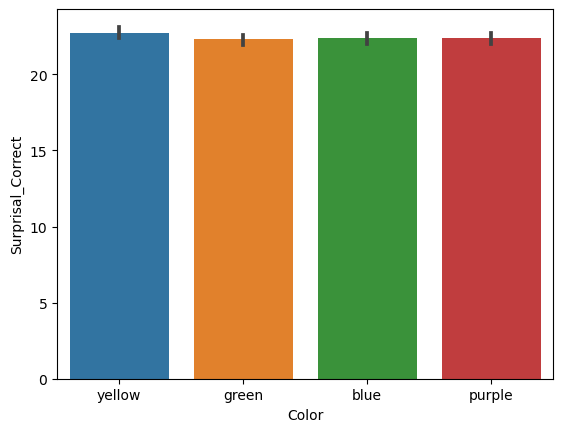

In [530]:
sns.barplot(data = results2, x = "Color", y = "Surprisal_Correct")

<Axes: xlabel='Color', ylabel='Response_Surprisal'>

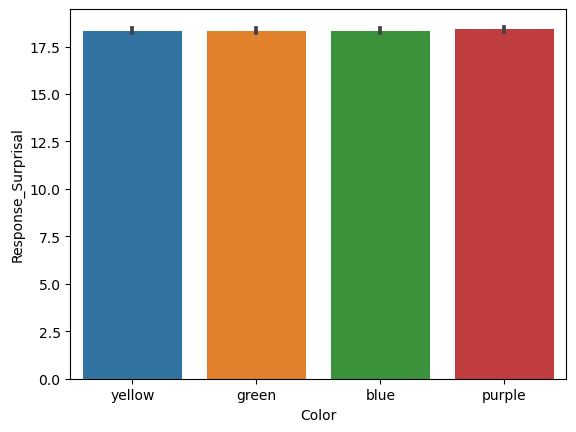

In [531]:
sns.barplot(data = results2, x = "Color", y = "Response_Surprisal")

In [536]:
# Group by whether GPT guessed correctly means
grouped_correct = results2.groupby('Correct').mean()
grouped_correct

,Response_Probability,Response_Surprisal,Probability_Correct,Surprisal_Correct
Correct,,,,
False,0.000005,18.353063,7.994629e-07,22.465178
True,0.000004,17.941971,3.995593e-06,17.941971


In [542]:
# Group by whether GPT guessed correctly counts
grouped_correct = results2.groupby('Correct').count()
grouped_correct

,Game_ID,Prompt,Color,Category,Response,Response_Probability,Response_Surprisal,Correct_Answer,Probability_Correct,Surprisal_Correct
Correct,,,,,,,,,,
False,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119
True,4,4,4,4,4,4,4,4,4,4


<Axes: xlabel='Correct', ylabel='Response_Surprisal'>

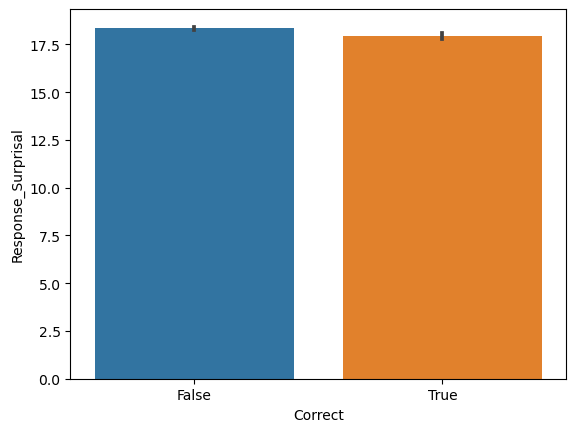

In [538]:
sns.barplot(data = results2, x = "Correct", y = "Response_Surprisal")